<a href="https://colab.research.google.com/github/Prashanti2004/HourlyEnergyConsumption_Project/blob/main/Copy_of_HourlyEnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Available states for analysis:
- Punjab
- Haryana
- Rajasthan
- Delhi
- UP
- Uttarakhand
- HP
- J&K
- Chandigarh
- Chhattisgarh
- Gujarat
- MP
- Maharashtra
- Goa
- DNH
- Andhra Pradesh
- Telangana
- Karnataka
- Kerala
- Tamil Nadu
- Pondy
- Bihar
- Jharkhand
- Odisha
- West Bengal
- Sikkim
- Arunachal Pradesh
- Assam
- Manipur
- Meghalaya
- Mizoram
- Nagaland
- Tripura

Enter the state to forecast (case-sensitive): Manipur


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training model for Manipur...
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.2560 - val_loss: 0.0380
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0412 - val_loss: 0.0230
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0318 - val_loss: 0.0132
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0238 - val_loss: 0.0134
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0234 - val_loss: 0.0145
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0232 - val_loss: 0.0130
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0238 - val_loss: 0.0146
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0217 - val_loss: 0.0129
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0216 - val_loss: 0.0130
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0187 - val_loss: 0.0136
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0206 - val_loss: 0.0129
Epoch 12/50
10/10 ━━━━━━━━━━━━━━

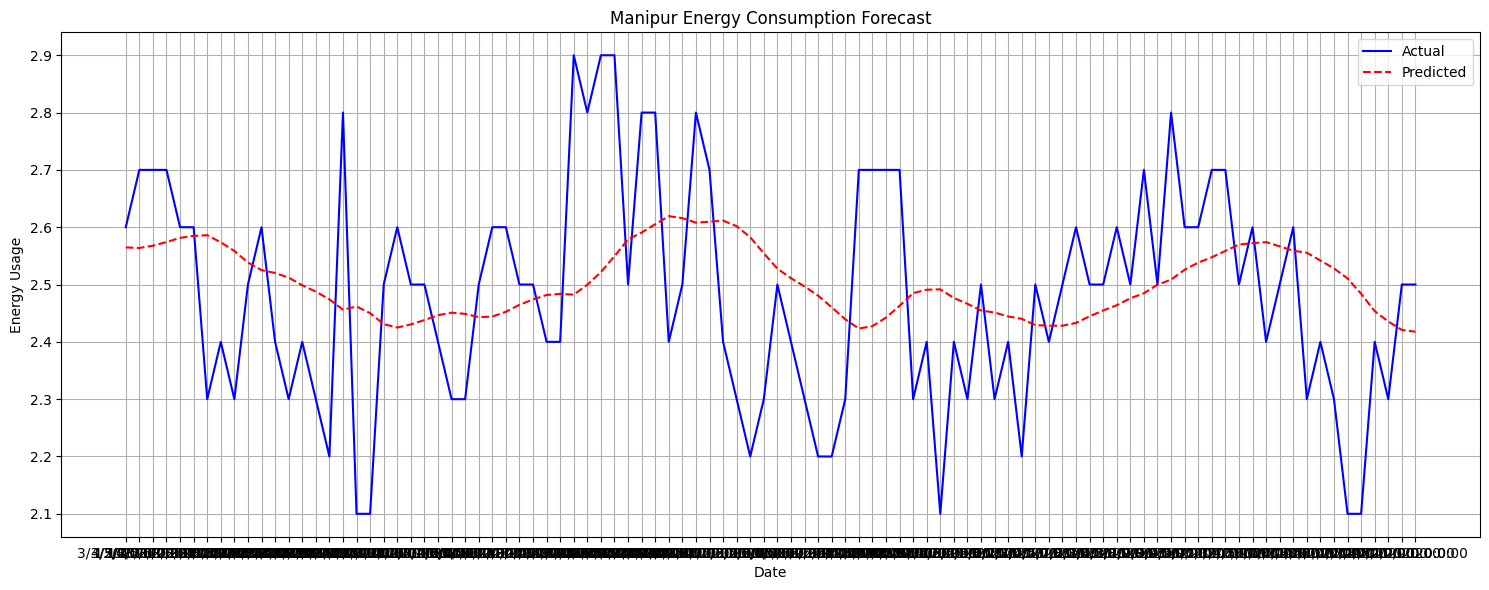


Forecast completed for Manipur!


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# 1. Load the Dataset
try:
    df = pd.read_csv('/content/Latest CSV dataset.csv', parse_dates=['Dates'], index_col='Dates')
except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
    exit()
except Exception as e:
    print(f"Error loading file: {e}")
    exit()

# 2. Data Preprocessing
# Display available states
available_states = df['States'].unique()
print("Available states for analysis:")
for state in available_states:
    print(f"- {state}")

# User input for state selection
selected_state = None
while selected_state not in available_states:
    selected_state = input("\nEnter the state to forecast (case-sensitive): ")
    if selected_state not in available_states:
        print("Invalid state. Please choose from the list above.")

# Filter data for selected state
state_data = df[df['States'] == selected_state].copy()

# Handle missing values
if state_data['Usage'].isnull().any():
    print("Handling missing values...")
    state_data['Usage'].fillna(method='ffill', inplace=True)
    state_data['Usage'].fillna(method='bfill', inplace=True)

# Convert to numeric
try:
    state_data['Usage'] = pd.to_numeric(state_data['Usage'], errors='coerce')
    if state_data['Usage'].isnull().any():
        state_data['Usage'].fillna(method='ffill', inplace=True)
except Exception as e:
    print(f"Error converting to numeric: {e}")
    exit()

# 3. Prepare Data for LSTM
sequence_length = 24  # Using 24 hours as lookback window

# Check sufficient data
if len(state_data) < sequence_length + 1:
    print(f"Error: Need at least {sequence_length + 1} data points.")
    exit()

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
state_data['Usage_Scaled'] = scaler.fit_transform(state_data['Usage'].values.reshape(-1, 1))

# Create sequences function
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        xs.append(data[i:(i + seq_length)])
        ys.append(data[i + seq_length])
    return np.array(xs), np.array(ys)

X, y = create_sequences(state_data['Usage_Scaled'].values, sequence_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# 4. Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# 5. Train Model
print(f"\nTraining model for {selected_state}...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# 6. Evaluate and Predict
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))

# 7. Plot Results
plt.figure(figsize=(15, 6))
plot_dates = state_data.index[train_size + sequence_length:train_size + sequence_length + len(y_test)]

plt.plot(plot_dates, y_test_original, label='Actual', color='blue')
plt.plot(plot_dates, predictions, label='Predicted', color='red', linestyle='--')
plt.title(f'{selected_state} Energy Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Energy Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nForecast completed for {selected_state}!")